In [34]:
import copy
import datetime
import random
import traceback

import numpy as np
import torch
from torch.utils.data import DataLoader


def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True


def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')


def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)





PROGRAM

In [35]:
!pip install youtokentome

In [36]:
#import pandas as pd
import re
import numpy as np
from itertools import chain

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset
import random
import youtokentome as yttm

Load data and preparing data

In [37]:
filename = '/kaggle/input/texts-datasets/texts.txt'
with open(filename) as input_file:
    phrases = input_file.read().split('\n')
    phrases = [' ' + line[:-1] for line in phrases]

In [38]:
quotes = pd.read_csv('/kaggle/input/texts-datasets/quotes_base.csv')
phrases+= list(quotes.Quote.values)

In [39]:
phrases = phrases[9:]

In [40]:
def save_text_to_file(texts,filename):
    with open(filename,'w') as outf:
        outf.write('\n'.join(texts))  

In [41]:
TOKEN_RE = re.compile(r"[a-zA-Z]+")



def tokenize_text_simple_regex(text,min_token_size=0):
    text = text.lower()
    text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("'d"," would")
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)
    
    all_tokens = TOKEN_RE.findall(text)
    return [token for token in all_tokens if len(token)>=min_token_size]
    
def tokenize_text(corpus,tokenizer=tokenize_text_simple_regex,**tokenizer_kwargs):
    return [tokenizer(txt,**tokenizer_kwargs) for txt in corpus]

In [42]:
phrase_token = tokenize_text(phrases)

In [43]:
phrase_token = [ph for ph in phrase_token if len(ph)<30 and len(ph)>3]

In [44]:
new_phrases = [' '.join(send) for send in phrase_token]
len(new_phrases)

301317

In [45]:
new_phrases = new_phrases[:40000]

In [46]:
np.random.shuffle(new_phrases)

SPLIT = int(len(new_phrases) * 0.7)

train_data = new_phrases[:SPLIT]
test_data = new_phrases[SPLIT:]

In [47]:
print("Size of train dataset: {}".format(len(train_data)))
print("Size of test dataset: {}".format(len(test_data)))

Size of train dataset: 28000
Size of test dataset: 12000


Tokenize text with BPE

In [48]:
def save_text_to_file(texts,filename):
    with open(filename,'w') as outf:
        outf.write('\n'.join(texts))     

In [49]:
FILE_BPE = 'quotes.yttm'
TRAIN_TEXT_FILENAME = 'train_quotes.txt'
save_text_to_file(train_data,TRAIN_TEXT_FILENAME)

In [50]:
yttm.BPE.train(data = TRAIN_TEXT_FILENAME,vocab_size = 1500,model = FILE_BPE )

In [51]:
tokenizer = yttm.BPE(FILE_BPE)

In [52]:
train_token_ids = tokenizer.encode(train_data, bos = True, eos = True)
test_token_ids = tokenizer.encode(test_data, bos = True, eos = True)

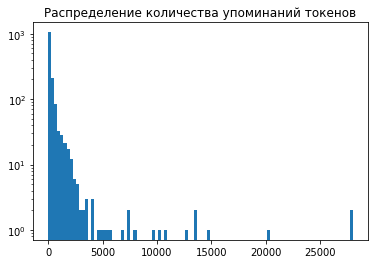

In [53]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [54]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


In [55]:
def ensure_lenght(txt, length,pad_value):
    if(length>len(txt)):
        return list(txt) + [pad_value] * (length - len(txt))
    else:
        return txt[:length]
    
class LanguageModelDataset(Dataset):
    def __init__(self,token_ids, chunk_length = 30,pad_value = 0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value
    def __len__(self):
        return len(self.token_ids)
    def __getitem__(self,item):
        
        text = self.token_ids[item]
        
        seed_part = text[1:-1]
        target_part = text[2:]
        
        seed_part = np.array(ensure_lenght(seed_part,self.chunk_length,self.pad_value))
        target_part = np.array(ensure_lenght(target_part,self.chunk_length,self.pad_value))
        
        return seed_part,target_part

In [56]:
train_dataset = LanguageModelDataset(train_token_ids, 34,pad_value = 0)
test_dataset =  LanguageModelDataset(test_token_ids, 34,pad_value = 0 )

In [57]:
tokenizer.decode(list(train_dataset[2]))

['trust no friend without faults and love a woman but no angel<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'no friend without faults and love a woman but no angel<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']

In [58]:
def make_dependency_target_mask(size):
    full_mask = torch.ones((size,size))
    ignore_mask = torch.tril(full_mask)<1
    full_mask.masked_fill_(ignore_mask,float('-inf'))
    full_mask.masked_fill_(~ignore_mask,0)
    return full_mask
                    
def make_positional_encoding(max_len,emb_size):
    time = np.pi * torch.arange(0,max_len).float()
    freq_dividers = torch.arange(1,emb_size//2+1)
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_len,emb_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

In [59]:
class LanguageModel(nn.Module):
    def __init__(self,vocab_size,emb_size,backbone,emb_dropout = 0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.embeddings = nn.Embedding(vocab_size,emb_size,padding_idx = 0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(emb_size,vocab_size)
        
    def forward(self,seed_token_ids):
        batch_size,max_in_len = seed_token_ids.shape
        
        seed_padding_mask = seed_token_ids == 0
        
        dependency_mask = make_dependency_target_mask(max_in_len).to(seed_token_ids.device)
        
        seed_emb = self.embeddings(seed_token_ids)
        
        pos_codes = make_positional_encoding(max_in_len,self.emb_size).unsqueeze(0).to(seed_token_ids.device)
        
        seed_emb = seed_emb + pos_codes
        seed_emb = self.emb_dropout(seed_emb)
        
        target_features = seed_emb
        target_features = self.backbone(seed_emb, mask = dependency_mask, src_key_padding_mask = seed_padding_mask)
        logits = self.out(target_features)
        return logits

In [60]:
def lm_cross_entropy(pred,target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1,pred.shape[-1])
    target_flat = target.view(-1)
    return F.cross_entropy(pred_flat,target_flat,ignore_index = 0)

def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 20, factor = 0.5, verbose = True)

In [61]:
class BatchFirstTranformerEncoder(nn.Module):
    def __init__(self,*args,**kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args,**kwargs)
        self.initialize_weights()
    def forward(self,src,*args,**kwargs):
        src = src.transpose(0,1).contiguous()
        result = self.impl(src,*args,**kwargs)
        result = result.transpose(0,1).contiguous()
        return result
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [69]:
model = LanguageModel(tokenizer.vocab_size(),128,BatchFirstTranformerEncoder(nn.TransformerEncoderLayer(d_model = 128,
                                                                                             nhead = 8,
                                                                                             dim_feedforward=512,
                                                                                             dropout=0.2),num_layers = 2),emb_dropout = 0.2)

In [70]:
(best_val_loss,
 best_torch_transf_model) = train_eval_loop(model,
                                            train_dataset,
                                            test_dataset,
                                            lm_cross_entropy,
                                            lr=2e-3,
                                            epoch_n=1000,
                                            batch_size=1024,
                                            device='cuda',
                                            early_stopping_patience=50,
                                            max_batches_per_epoch_train=1000,
                                            max_batches_per_epoch_val=1000,
                                            lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 28 итераций, 2.72 сек
Среднее значение функции потерь на обучении 6.381273337772915
Среднее значение функции потерь на валидации 6.080692807833354
Новая лучшая модель!

Эпоха 1
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 5.922126804079328
Среднее значение функции потерь на валидации 5.598604003588359
Новая лучшая модель!

Эпоха 2
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 5.505689263343811
Среднее значение функции потерь на валидации 5.191737691561381
Новая лучшая модель!

Эпоха 3
Эпоха: 28 итераций, 3.13 сек
Среднее значение функции потерь на обучении 5.192608850342887
Среднее значение функции потерь на валидации 4.934783418973287
Новая лучшая модель!

Эпоха 4
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 4.98303701196398
Среднее значение функции потерь на валидации 4.776018142700195
Новая лучшая модель!

Эпоха 5
Эпоха: 28 итераций, 2.74 сек
Среднее значение функции потерь на обучении 

Среднее значение функции потерь на валидации 4.1188987493515015
Новая лучшая модель!

Эпоха 45
Эпоха: 28 итераций, 2.71 сек
Среднее значение функции потерь на обучении 4.1142071315220425
Среднее значение функции потерь на валидации 4.115487734476726
Новая лучшая модель!

Эпоха 46
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 4.1089102029800415
Среднее значение функции потерь на валидации 4.110737403233846
Новая лучшая модель!

Эпоха 47
Эпоха: 28 итераций, 2.87 сек
Среднее значение функции потерь на обучении 4.104091831615993
Среднее значение функции потерь на валидации 4.1098655462265015
Новая лучшая модель!

Эпоха 48
Эпоха: 28 итераций, 2.74 сек
Среднее значение функции потерь на обучении 4.098713517189026
Среднее значение функции потерь на валидации 4.10413642724355
Новая лучшая модель!

Эпоха 49
Эпоха: 28 итераций, 2.71 сек
Среднее значение функции потерь на обучении 4.09728331225259
Среднее значение функции потерь на валидации 4.105313102404277

Эпоха 50


Эпоха: 28 итераций, 2.70 сек
Среднее значение функции потерь на обучении 3.975362079484122
Среднее значение функции потерь на валидации 4.032335996627808
Новая лучшая модель!

Эпоха 92
Эпоха: 28 итераций, 2.73 сек
Среднее значение функции потерь на обучении 3.975139081478119
Среднее значение функции потерь на валидации 4.030007998148601
Новая лучшая модель!

Эпоха 93
Эпоха: 28 итераций, 2.73 сек
Среднее значение функции потерь на обучении 3.9745149442127774
Среднее значение функции потерь на валидации 4.028994560241699
Новая лучшая модель!

Эпоха 94
Эпоха: 28 итераций, 2.70 сек
Среднее значение функции потерь на обучении 3.97181499004364
Среднее значение функции потерь на валидации 4.028562347094218
Новая лучшая модель!

Эпоха 95
Эпоха: 28 итераций, 3.02 сек
Среднее значение функции потерь на обучении 3.967358274119241
Среднее значение функции потерь на валидации 4.0273706912994385
Новая лучшая модель!

Эпоха 96
Эпоха: 28 итераций, 2.73 сек
Среднее значение функции потерь на обучении 3

Среднее значение функции потерь на валидации 3.9973233342170715
Новая лучшая модель!

Эпоха 138
Эпоха: 28 итераций, 2.71 сек
Среднее значение функции потерь на обучении 3.9076477033751353
Среднее значение функции потерь на валидации 3.9966522455215454
Новая лучшая модель!

Эпоха 139
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.904096645968301
Среднее значение функции потерь на валидации 3.9952046275138855
Новая лучшая модель!

Эпоха 140
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 3.9057642817497253
Среднее значение функции потерь на валидации 3.996839463710785

Эпоха 141
Эпоха: 28 итераций, 3.09 сек
Среднее значение функции потерь на обучении 3.9048433559281484
Среднее значение функции потерь на валидации 3.9962047139803567

Эпоха 142
Эпоха: 28 итераций, 2.72 сек
Среднее значение функции потерь на обучении 3.9043281248637607
Среднее значение функции потерь на валидации 3.9940011898676553
Новая лучшая модель!

Эпоха 143
Эпоха: 2

Среднее значение функции потерь на валидации 3.980306406815847

Эпоха 185
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.8631231614521573
Среднее значение функции потерь на валидации 3.9760474960009256
Новая лучшая модель!

Эпоха 186
Эпоха: 28 итераций, 2.68 сек
Среднее значение функции потерь на обучении 3.86394773210798
Среднее значение функции потерь на валидации 3.9775261680285134

Эпоха 187
Эпоха: 28 итераций, 2.70 сек
Среднее значение функции потерь на обучении 3.8633788568632945
Среднее значение функции потерь на валидации 3.974985738595327
Новая лучшая модель!

Эпоха 188
Эпоха: 28 итераций, 2.86 сек
Среднее значение функции потерь на обучении 3.8606960603169034
Среднее значение функции потерь на валидации 3.9786193569501243

Эпоха 189
Эпоха: 28 итераций, 3.19 сек
Среднее значение функции потерь на обучении 3.8628010409218922
Среднее значение функции потерь на валидации 3.9765857259432473

Эпоха 190
Эпоха: 28 итераций, 2.77 сек
Среднее значение функци

Среднее значение функции потерь на валидации 3.966730078061422

Эпоха 233
Эпоха: 28 итераций, 2.75 сек
Среднее значение функции потерь на обучении 3.8326919163976396
Среднее значение функции потерь на валидации 3.9659403363863626

Эпоха 234
Эпоха: 28 итераций, 2.66 сек
Среднее значение функции потерь на обучении 3.8323016677583968
Среднее значение функции потерь на валидации 3.9666628241539

Эпоха 235
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.83187883240836
Среднее значение функции потерь на валидации 3.965212961037954

Эпоха 236
Эпоха: 28 итераций, 2.71 сек
Среднее значение функции потерь на обучении 3.8312143427985057
Среднее значение функции потерь на валидации 3.9650288224220276

Эпоха 237
Эпоха: 28 итераций, 2.68 сек
Среднее значение функции потерь на обучении 3.829640277794429
Среднее значение функции потерь на валидации 3.964125315348307
Новая лучшая модель!

Эпоха 238
Эпоха: 28 итераций, 2.74 сек
Среднее значение функции потерь на обучении 3.828

Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.8108489768845693
Среднее значение функции потерь на валидации 3.9583279887835183

Эпоха 282
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 3.806693570954459
Среднее значение функции потерь на валидации 3.9584790070851645

Эпоха 283
Эпоха: 28 итераций, 3.00 сек
Среднее значение функции потерь на обучении 3.8088907258851186
Среднее значение функции потерь на валидации 3.9600701928138733

Эпоха 284
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.807196242468698
Среднее значение функции потерь на валидации 3.9594478209813437

Эпоха 285
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 3.807039133140019
Среднее значение функции потерь на валидации 3.9584004084269204

Эпоха 286
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 3.8090705275535583
Среднее значение функции потерь на валидации 3.9571956793467202
Новая лучшая

Эпоха: 28 итераций, 3.32 сек
Среднее значение функции потерь на обучении 3.791569326605116
Среднее значение функции потерь на валидации 3.951316157976786
Новая лучшая модель!

Эпоха 331
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.7927370241710117
Среднее значение функции потерь на валидации 3.9528403679529824

Эпоха 332
Эпоха: 28 итераций, 2.80 сек
Среднее значение функции потерь на обучении 3.7896886808531627
Среднее значение функции потерь на валидации 3.9508692820866904
Новая лучшая модель!

Эпоха 333
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 3.79273191520146
Среднее значение функции потерь на валидации 3.9511354764302573

Эпоха 334
Эпоха: 28 итераций, 2.66 сек
Среднее значение функции потерь на обучении 3.7918761542865207
Среднее значение функции потерь на валидации 3.950259268283844
Новая лучшая модель!

Эпоха 335
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.7901110649108887
Среднее значени

Среднее значение функции потерь на валидации 3.94859778881073

Эпоха 379
Эпоха: 28 итераций, 2.71 сек
Среднее значение функции потерь на обучении 3.7779535140310014
Среднее значение функции потерь на валидации 3.9504012068112693

Эпоха 380
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.7788089088031223
Среднее значение функции потерь на валидации 3.948110560576121

Эпоха 381
Эпоха: 28 итераций, 2.66 сек
Среднее значение функции потерь на обучении 3.7771719098091125
Среднее значение функции потерь на валидации 3.948374589284261

Эпоха 382
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 3.7780955689293996
Среднее значение функции потерь на валидации 3.9482264717419944
Epoch   383: reducing learning rate of group 0 to 1.0000e-03.

Эпоха 383
Эпоха: 28 итераций, 2.74 сек
Среднее значение функции потерь на обучении 3.7649394273757935
Среднее значение функции потерь на валидации 3.9463549653689065
Новая лучшая модель!

Эпоха 384
Эпоха: 28 и

Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.732451779501779
Среднее значение функции потерь на валидации 3.9387250542640686

Эпоха 427
Эпоха: 28 итераций, 2.66 сек
Среднее значение функции потерь на обучении 3.7313002943992615
Среднее значение функции потерь на валидации 3.938959320386251

Эпоха 428
Эпоха: 28 итераций, 2.74 сек
Среднее значение функции потерь на обучении 3.735133537224361
Среднее значение функции потерь на валидации 3.939483722050985

Эпоха 429
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.7330627271107266
Среднее значение функции потерь на валидации 3.9389341274897256

Эпоха 430
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.732257059642247
Среднее значение функции потерь на валидации 3.9389073053995767

Эпоха 431
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 3.731546555246626
Среднее значение функции потерь на валидации 3.938546081384023

Эпоха 432
Эпоха

Среднее значение функции потерь на валидации 3.9372642834981284

Эпоха 475
Эпоха: 28 итераций, 2.71 сек
Среднее значение функции потерь на обучении 3.721888073853084
Среднее значение функции потерь на валидации 3.9369158943494162
Новая лучшая модель!

Эпоха 476
Эпоха: 28 итераций, 2.70 сек
Среднее значение функции потерь на обучении 3.7215187634740556
Среднее значение функции потерь на валидации 3.9380250374476113

Эпоха 477
Эпоха: 28 итераций, 2.73 сек
Среднее значение функции потерь на обучении 3.7227359669549123
Среднее значение функции потерь на валидации 3.937531371911367

Эпоха 478
Эпоха: 28 итераций, 2.69 сек
Среднее значение функции потерь на обучении 3.7210061124392917
Среднее значение функции потерь на валидации 3.9369864662488303

Эпоха 479
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.7221332362719943
Среднее значение функции потерь на валидации 3.937338173389435

Эпоха 480
Эпоха: 28 итераций, 3.07 сек
Среднее значение функции потерь на обучении

Среднее значение функции потерь на валидации 3.9370716412862143

Эпоха 524
Эпоха: 28 итераций, 2.67 сек
Среднее значение функции потерь на обучении 3.717869349888393
Среднее значение функции потерь на валидации 3.9370112816492715

Эпоха 525
Эпоха: 28 итераций, 2.70 сек
Среднее значение функции потерь на обучении 3.717998504638672
Среднее значение функции потерь на валидации 3.9369606375694275

Эпоха 526
Эпоха: 28 итераций, 2.94 сек
Среднее значение функции потерь на обучении 3.717379799910954
Среднее значение функции потерь на валидации 3.9369558691978455
Модель не улучшилась за последние 50 эпох, прекращаем обучение


In [71]:
torch.save(best_torch_transf_model.state_dict(), 'quotes_model.pth')

In [73]:
model.load_state_dict(torch.load('quotes_model.pth'))

<All keys matched successfully>

In [87]:
import heapq
class BeamGenerator():
    def __init__(self,model,tokenizer,device = 'cuda',eos_token_id = 3):
        self.model = model
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id
        self.tokenizer = tokenizer
    def __call__(self,seed_text,max_steps_n = 40, beamsize = 5, return_hypotheses_n = 5):
        
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_len = len(seed_tokens)
        
        partial_hyp = [(0,seed_tokens)]
        final = []
        
        while(len(partial_hyp) > 0):
            cur_partial_score, cur_partial_hyp = heapq.heappop(partial_hyp)
            in_batch = torch.tensor(cur_partial_hyp).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0,-1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            topk_continuations = next_tokens_logproba.topk(beamsize)
            
            for token_score, token_idx in zip(topk_continuations.values,topk_continuations.indices):
                
                token_score = float(token_score)
                token_idx = int(token_idx)
                
                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hyp))
                new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hyp)+1)
                
                new_hyp = cur_partial_hyp + [token_idx]
                new_item = (new_score,new_hyp)
                
                if token_idx == self.eos_token_id or len(new_hyp) - initial_len >= max_steps_n:
                    final.append(new_item)
                else:
                    heapq.heappush(partial_hyp,new_item)
            if(len(partial_hyp) > beamsize):
                partial_hyp = heapq.nsmallest(beamsize,partial_hyp)
                heapq.heapify(partial_hyp)
        final_scores, final_token_list = zip(*final)
        
        final_text = self.tokenizer.decode(list(final_token_list))
        
        result = list(zip(final_scores,final_text))
        result.sort()
        result = result[:return_hypotheses_n]
        
        return result
        

In [88]:
beam_generator = BeamGenerator(model,tokenizer)

In [259]:
%%time

beam_gen_variants = beam_generator('love',
                                   beamsize=10,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt[:-5])
    print()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


****
4.020973865670746
love is the best thing

****
4.050088717587435
love does not make you happy

****
4.089896519978841
love is one of the most important thing

****
4.227022245172906
love is the best thing to do

****
4.56889533996582
love is one of the most beautiful things

CPU times: user 1.23 s, sys: 17.5 ms, total: 1.25 s
Wall time: 1.25 s


In [238]:
class RandomGeneration():
    def __init__(self,model,tokenizer,device = 'cuda',eos_token_id = 3):
        self.model = model
        self.tokenizer = tokenizer
        self.eos_token_id = eos_token_id
        self.device = torch.device(device)
        self.model.to(self.device)
        
    def __call__(self,seed_phrase = '  ', temperature = 1.0,max_steps_n = 1000):
        seed_tokens = tokenizer.encode(list([seed_phrase]))[0]
        vocab_size = (self.tokenizer.vocab_size())
                      
        if len (seed_tokens) == 0:
            seed_tokens.append(2)
                      
        for _ in range(max_steps_n):
            in_batch = torch.tensor(seed_tokens).unsqueeze(0).to(self.device)
            logits = self.model(in_batch)[0,-1]
            logproba = F.softmax(logits/temperature).cpu().detach().numpy()
            
            next_token = np.random.choice(vocab_size,p = logproba)
            seed_tokens.append(next_token)
            
            if(next_token == self.eos_token_id): break
        
        return self.tokenizer.decode([seed_tokens])[0][:-5]

In [239]:
generation = RandomGeneration(model,tokenizer)

In [263]:
for _ in range(10):
    print(generation(seed_phrase = 'love',temperature = 0.5))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


love is the last thing that is not a memory
love is the greatest thing that the most beautiful things are ever done
love is a dishonest
love is not a great deal of faith
love is a gift when you love someone you love someone else you have to be happy
love is the only thing that is possible if you are not to be loved
love is the most powerful thing in life
love is a good thing
love is a pleasant thing that is not so much more important than a man to be so large as a man
love is not a dreaming but only a dream of life


In [307]:
class RandomGenerationStepTemp():
    def __init__(self,model,tokenizer,device = 'cuda',eos_token_id = 3):
        self.model = model
        self.tokenizer = tokenizer
        self.eos_token_id = eos_token_id
        self.device = torch.device(device)
        self.model.to(self.device)
        
    def __call__(self,seed_phrase = '  ', temperature = 1.0,size_step = 10,step = 0.1,max_steps_n = 100):
        seed_tokens = tokenizer.encode(list([seed_phrase]))[0]
        vocab_size = (self.tokenizer.vocab_size())
                      
        if len (seed_tokens) == 0:
            seed_tokens.append(2)
                      
        for i in range(max_steps_n):
            in_batch = torch.tensor(seed_tokens).unsqueeze(0).to(self.device)
            logits = self.model(in_batch)[0,-1]
            logproba = F.softmax(logits/temperature).cpu().detach().numpy()
            
            next_token = np.random.choice(vocab_size,p = logproba)
            seed_tokens.append(next_token)
            if(i%size_step == 0):
                temperature = temperature - step
                if(temperature<=0):temperature = 0.1
            
            if(next_token == self.eos_token_id): break
        
        return self.tokenizer.decode([seed_tokens])[0][:-5]

In [308]:
generation_step = RandomGenerationStepTemp(model,tokenizer)

In [321]:
for _ in range(10):
    print(generation_step(seed_phrase = 'freedom',temperature = 0.5,size_step = 2,step = 0.05))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


freedom is a gift of life
freedom is the key to the united states and the mind
freedom is the last thing that you have to be loved
freedom is a choice that is the greatest virtue of the world
freedom is the key to happiness
freedom is a great thing of the most important thing to do is to be happy
freedom is a man who is not afraid of the world
freedom is a virtue of a man
freedom is the key to the lonely and the greatest of the world
freedom is not the ability to make it easier to be able to be able to be able to be a man own mind
